In [12]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.signal import fft2d, ifft2d
import os
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images
from UNet_Fourier_Facilities_Fake import UNet_Label_Gen_Fake


In [13]:
tf.compat.v1.disable_eager_execution()


INFO:tensorflow:Disabling eager execution


In [14]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Load Images

In [15]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\water\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\water\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [16]:
train_filmed_imgs = []
train_clean_imgs = []

In [17]:
OFFSET = 400

for addr_filmed in os.listdir(TRAIN_FILMED_PATH):
    img = plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
    train_filmed_imgs.append(
        img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET])

for addr_clean in os.listdir(TRAIN_CLEAN_PATH):
    img = plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
    train_clean_imgs.append(
        img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET])


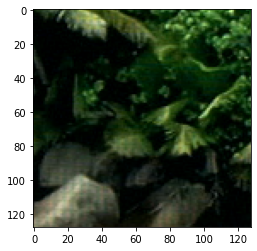

In [18]:
plt.imshow(train_filmed_imgs[0])
plt.show()


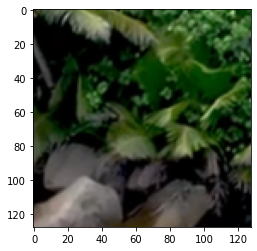

In [19]:
plt.imshow(train_clean_imgs[0])
plt.show()


## Build model

In [20]:
inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), batch_size=None)

# Hier werden Preprocessing-Schritte ausgeführt
# s ist hier dann Differnzbild (Pixelraum_Fourier)
s = Lambda(lambda x: x / 255)(inputs)


# Contraction path
c1 = Conv2D(
    16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

u_net_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy',
#               metrics=['accuracy'])
u_net_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

## Train Model

In [21]:
def create_fake_boolean_array(height, width):
    a = np.empty([height, width])
    return np.array(a, dtype=bool)
# print(create_fake_boolean_array(128,128).shape)

def create_fake_complex_array(height, width):
    a = np.empty([height, width])
    return np.array(a, dtype=complex)

a = create_fake_complex_array(128,128)
print(type(a[0][0]))

<class 'numpy.complex128'>


In [22]:
# Custom train loop

graph_UNet_model = tf.function(u_net_model)

num_epochs = 1
optimizer = tf.keras.optimizers.Adam()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.binary_crossentropy
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

x_filmed_fourier_px_ph = tf.compat.v1.placeholder(
    tf.float32, shape=(IMG_WIDTH, IMG_HEIGHT), name="x_filmed_fourier_px_ph")
x_clean_fourier_px_ph = tf.compat.v1.placeholder(
    tf.float32, shape=(IMG_WIDTH, IMG_HEIGHT), name="x_clean_fourier_px_ph")

x_filmed_fourier_complex_ph = tf.compat.v1.placeholder(
    tf.complex128, shape=(IMG_WIDTH, IMG_HEIGHT), name="x_filmed_fourier_complex_ph")
x_clean_fourier_complex_ph = tf.compat.v1.placeholder(
    tf.complex128, shape=(IMG_WIDTH, IMG_HEIGHT), name="x_clean_fourier_complex_ph")

difference_img_fourier_px_ph = tf.compat.v1.placeholder(
    tf.bool, shape=(IMG_WIDTH, IMG_HEIGHT), name="difference_img_fourier_px_ph")
u_net_output_px_ph = tf.compat.v1.placeholder(
    tf.float32, shape=(IMG_WIDTH, IMG_HEIGHT), name="u_net_output_px_ph")

alpha_value_for_threshold = tf.constant(
    0.5, dtype=tf.float16, shape=None, name='alpha_value_for_threshold'
)

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(num_epochs):
        print(f"Start of epoch {epoch}")

        train_step = 0
        # X_train: müsste bei mir ein Iterator sein, welcher 1 Bild zurückgibt (1, 128, 128, 3)
        for x_filmed, x_clean in tqdm(zip(train_filmed_imgs, train_clean_imgs), desc="training...", ascii=False, ncols=75):

            with tf.GradientTape() as tape:
                # Start Preprocessing: RGB_clean, RGB_filmed (könnte man irgendwo implementieren - normales Python)
                # Input: Fourier_clean und Fourier_filmed  (Datatype: tf.complex)
                ## fft2(RGB_clean), fft2(RGB_filmed)
                # Erster Schritt:  Fourier_clean - Fourier_filmed (im komplexen Raum? Bisher im Pixel_Fourier)

                # ---- Versuch, das Preprocessing mit Tensorflow zu machen ---
                # x_filmed_fourier_p = fft2d(x_filmed)
                # x_clean_fourier_px = fft2d(x_clean)
                # differenzbild_fourier_px = tf.math.subtract(
                #     x_filmed_fourier_p, x_clean_fourier_px)
                # proto_tensor = tf.make_tensor_proto(differenzbild_fourier_px)
                # print(type(proto_tensor))
                # with tf.compat.v1.Session() as sess:
                #     sess.run(init)
                #     differenzbild_fourier_px = sess.run(
                #         tf.compat.v1.numpy_function, feed_dict=differenzbild_fourier_px)

                # differenzbild_fourier_px = differenzbild_fourier_px.eval(
                #     session=tf.compat.v1.Session())
                # print(type(differenzbild_fourier_px))

                # ---- Preprocessing mit Python ----

                fourier_handler = Fourier_Images(x_filmed, x_clean)

                img_filmed_r, img_filmed_g, img_filmed_b = fourier_handler.split_RGB_2_Grayscale(
                    x_filmed)
                img_clean_r, img_clean_g, img_clean_b = fourier_handler.split_RGB_2_Grayscale(
                    x_clean)

                img_filmed_complex_r = fourier_handler.grayscale_2_Fourier(
                    img_filmed_r)
                img_filmed_complex_g = fourier_handler.grayscale_2_Fourier(
                    img_filmed_g)
                img_filmed_complex_b = fourier_handler.grayscale_2_Fourier(
                    img_filmed_b)

                img_clean_complex_r = fourier_handler.grayscale_2_Fourier(
                    img_filmed_r)
                img_clean_complex_g = fourier_handler.grayscale_2_Fourier(
                    img_filmed_g)
                img_clean_complex_b = fourier_handler.grayscale_2_Fourier(
                    img_filmed_b)

                x_filmed_fourier_px, x_clean_fourier_px, differenzbild_fourier_px = fourier_handler.generate_mask_from_images()
                differenzbild_fourier_px = differenzbild_fourier_px.reshape(
                    1, IMG_WIDTH, IMG_HEIGHT, 1)

                del(fourier_handler)

                # plt.imshow(x_filmed_fourier_px)
                # plt.show()
                # print(differenzbild_fourier_px.reshape((IMG_WIDTH, IMG_HEIGHT, 1)).shape)
                # print(type(differenzbild_fourier_px[0][0]))
                # plt.imshow(differenzbild_fourier_px, cmap="gray")
                # plt.show()

                # ----------- HIER STARTET MODEL (UNet) -----------
                # c1(Differenzbild)
                # y_pred: Segmentierungsmaske (weights anpassen) U-Net (als Blackbox verwenden!)
                # Output: leicht verändertes Differenzbild (Werte zwischen 0..1 -> Sigmoid)
                # HIER ENDET MODEL (UNet)

                # print(type(differenzbild_fourier_px))
                # differenzbild_fourier_px = tf.reshape(differenzbild_fourier_px, shape=[
                #                                    1, IMG_WIDTH, IMG_HEIGHT, 3])
                # print(differenzbild_fourier_px.shape)

                u_net_output = graph_UNet_model(differenzbild_fourier_px, training=True)
                print("u_net_output: ")
                print(u_net_output)

                # print(u_net_output.shape)
                # print(type(u_net_output))

                # with tf.compat.v1.Session() as sess:
                #     sess.run(init)
                #     u_net_output = sess.run(u_net_model, feed_dict={difference_img_fourier_px_ph: differenzbild_fourier_px})

                # print(u_net_output)

                # plt.imshow(u_net_output.numpy().reshape(IMG_WIDTH, IMG_HEIGHT, 1))
                # plt.show()

                # ----------- HIER STARTET ALPHA-BLENDING -----------

                # -> Alpha Blending "soft" (alternativ die Funktionen aus Facilities verwenden)(reine Berechnung)
                # Input: Differenzbild UND zwei Variablen (tf.Placeholder) für Fourier_clean und Fourier_filmed
                # -> result = ifft (reine Berechnung)
                # Input: Fourier_processed Output: Bild in RGB-Domain

                # a = tf.compat.v1.placeholder(tf.int32, shape=[4], name="a")
                # sum_of_a = tf.reduce_sum(a, name="sum_of_a")
                # with tf.compat.v1.Session() as sess:
                #     print("Sum(a): ", sess.run(sum_of_a, feed_dict={a: [1,2,3,4]}))

                # @tf.function
                # def alpha_blending(x_filmed_fourier_px_ph, x_clean_fourier_complex_ph, u_net_output_px_ph):
                #     return tfa.image.blend(x_filmed_fourier_px_ph, x_clean_fourier_complex_ph, u_net_output_px_ph)

                my_tf_function = tf.math.multiply(
                    x_filmed_fourier_px_ph, x_filmed_fourier_px_ph
                )

                tf_func_where = tf.where(
                    condition=difference_img_fourier_px_ph,
                    x=x_filmed_fourier_complex_ph,
                    y=x_clean_fourier_complex_ph
                )

                # tf_func_step = tf.js.step(
                #     x=difference_img_fourier_px_ph,
                #     alpha = alpha_value_for_threshold
                # )

                u_net_output_evaluated = u_net_output.eval().reshape(IMG_WIDTH, IMG_HEIGHT)

                # u_net_output_evaluated = sess.run(tf.js.step, feed_dict={
                #     difference_img_fourier_px_ph: u_net_output_evaluated,
                # })
                to_int = lambda x: tf.cast(x, tf.int32)
                u_net_output_evaluated = to_int(u_net_output_evaluated)
                # u_net_output_evaluated = u_net_output.eval()
                print("nach to int  u_net_output_evaluated: ")
                print(u_net_output_evaluated[0][0])

                to_bool = lambda x: tf.cast(x, tf.bool)
                u_net_output_evaluated = to_bool(u_net_output_evaluated)
                u_net_output_evaluated = u_net_output.eval().reshape(IMG_WIDTH, IMG_HEIGHT)
                print("nach to bool  u_net_output_evaluated: ")
                print(u_net_output_evaluated[0][0])

                print("----------------- img_filmed_complex_r: ")
                print(img_filmed_complex_r.shape)
                print("----------------- img_clean_complex_r: ")
                print(img_clean_complex_r.shape)

                u_net_output_evaluated = create_fake_boolean_array(128,128)
                img_filmed_complex_r = create_fake_complex_array(128,128)
                img_clean_complex_r = create_fake_complex_array(128,128)

                # differ = create_fake_boolean_array(IMG_WIDTH, IMG_WIDTH)
                # xf = create_fake_complex_array(IMG_WIDTH, IMG_WIDTH)
                # xc = create_fake_complex_array(IMG_WIDTH, IMG_WIDTH)



                


                tmp_processed = sess.run(tf_func_where, feed_dict={
                    difference_img_fourier_px_ph: u_net_output_evaluated,
                    x_filmed_fourier_px_ph: img_filmed_complex_r,
                    x_clean_fourier_px_ph: img_clean_complex_r
                })
                print("NOCH DAAAAAAAAAAAAAAAAAA")       

                # fourier_processed = sess.run(alpha_blending, feed_dict={
                #     x_filmed_fourier_pxx_ph: x_filmed,
                #     x_clean_fourier_pxx_ph: x_clean,
                #     u_net_output_px_ph: u_net_output_evaluated})

                plt.imshow(tmp_processed, cmap="gray")
                plt.show()

                # ALIASING-CNN verwenden
                # predict_aliasing(result) (nicht die weights verändern!)
                # Input: RGB/Bild    Output: 2D Matrix mit 0..1 Wahrscheinlichkeiten für Aliasing

                # loss funktion
                # Loss wird pro Kachel berechnet
                # Fake Fake_lables: ausschließlich kein Aliasing! -> 2D Matrix mit 0
                ## y_pred = Kacheln
                # crossentropy -> loss_fn(Fake_lables, y_pred)

                # HIGH-LEVEL Programmierung
                # rgb_processed = alpha_blending(u_net_output, rgb_clean_fft, rgb_filmed_fft)
                # y_pred = cnn_model(rgb_processed, training=False)
                # loss = loss_fn(y_pred, fake_labels)
                # gradients = tape.gradient(loss, model.trainable_weights)
                # optimizer.apply_gradients(zip(gradients, model.trainable_weights))

                loss = loss_fn(y_batch.reshape(-1, 128, 128, 1), u_net_output)

            gradients = tape.gradient(loss, u_net_model.trainable_weights)
            optimizer.apply_gradients(
                zip(gradients, u_net_model.trainable_weights))
            acc_metric.update_state(
                y_batch.reshape(-1, 128, 128, 1), u_net_output)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1

    train_acc = acc_metric.result()
    print(f"Accuracy over epoch {train_acc}")
    acc_metric.reset_states()


Start of epoch 0


training...: 0it [00:00, ?it/s]

u_net_output: 
Tensor("StatefulPartitionedCall_1:0", shape=(1, 128, 128, 1), dtype=float32)
nach to int  u_net_output_evaluated: 


training...: 0it [00:00, ?it/s]

Tensor("strided_slice_3:0", shape=(), dtype=int32)
nach to bool  u_net_output_evaluated: 
0.49989036
----------------- img_filmed_complex_r: 
(128, 128)
----------------- img_clean_complex_r: 
(128, 128)


InvalidArgumentError: You must feed a value for placeholder tensor 'x_clean_fourier_complex_ph_1' with dtype complex128 and shape [128,128]
	 [[node x_clean_fourier_complex_ph_1 (defined at <ipython-input-22-b4bbd818705f>:21) ]]

Original stack trace for 'x_clean_fourier_complex_ph_1':
  File "D:\Python_39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\Python_39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\Python_39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Python_39\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "D:\Python_39\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "D:\Python_39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "D:\Python_39\lib\asyncio\windows_events.py", line 316, in run_forever
    super().run_forever()
  File "D:\Python_39\lib\asyncio\base_events.py", line 596, in run_forever
    self._run_once()
  File "D:\Python_39\lib\asyncio\base_events.py", line 1890, in _run_once
    handle._run()
  File "D:\Python_39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "D:\Python_39\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "D:\Python_39\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "D:\Python_39\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "D:\Python_39\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "D:\Python_39\lib\site-packages\ipykernel\kernelbase.py", line 358, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "D:\Python_39\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "D:\Python_39\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "D:\Python_39\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "D:\Python_39\lib\site-packages\ipykernel\kernelbase.py", line 536, in execute_request
    self.do_execute(
  File "D:\Python_39\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "D:\Python_39\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Python_39\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Python_39\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
    result = self._run_cell(
  File "D:\Python_39\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
    return runner(coro)
  File "D:\Python_39\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "D:\Python_39\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "D:\Python_39\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "D:\Python_39\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-b4bbd818705f>", line 21, in <module>
    x_clean_fourier_complex_ph = tf.compat.v1.placeholder(
  File "D:\Python_39\lib\site-packages\tensorflow\python\ops\array_ops.py", line 3271, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "D:\Python_39\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 6744, in placeholder
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "D:\Python_39\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "D:\Python_39\lib\site-packages\tensorflow\python\framework\ops.py", line 3557, in _create_op_internal
    ret = Operation(
  File "D:\Python_39\lib\site-packages\tensorflow\python\framework\ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


## Tests...

In [ ]:
condition = tf.compat.v1.placeholder(dtype=tf.bool, shape=[2,2])
x = tf.compat.v1.placeholder(dtype=tf.complex64, shape=[2,2])
y = tf.compat.v1.placeholder(dtype=tf.complex64, shape=[2,2])


my_func = tf.where(condition, x, y)


with tf.compat.v1.Session() as sess:
    print("In session")

    
    result = sess.run(my_func, feed_dict=({
        condition: [[True, True], [False, True]],
        x: [[5+4j, 5+4j], [5+4j, 5+4j]],
        y: [[6+4j, 6+4j], [6+4j, 6+4j]]
        }))
    print(result)


In session
[[5.+4.j 5.+4.j]
 [6.+4.j 5.+4.j]]


In [ ]:
a = np.array([[5+4j,1], [1,0]])
# [bool(x) for x in a]
print(a)
a.astype(dtype=bool)

[[0 1]
 [1 0]]


array([[False,  True],
       [ True, False]])

In [ ]:
print(type(5+4j))

<class 'complex'>
